In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

In [2]:
from google.colab import drive
drive.mount('/content/drive/') 

Mounted at /content/drive/


In [3]:
labels = ['Abnormal(Ulcer)','Normal(Healthy skin)']

In [4]:
X_train = []
y_train = []
image_size = 224
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/DFU_dataset','train',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        try:
            img = cv2.resize(img,(image_size, image_size))
        except:
            break
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/DFU_dataset','test',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 110/110 [00:02<00:00, 38.24it/s]


In [5]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)


In [6]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.2,random_state=101)

In [7]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [8]:
import keras
import keras.utils
from keras import utils as np_utils
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
import keras.backend as k
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
from keras.utils.vis_utils import plot_model
from keras.initializers import glorot_uniform
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D

In [9]:
k.clear_session()
def inception_module(x, f1, f2):
		# 1x1 conv
		conv1 = keras.layers.Conv2D(f1, (1,1), strides=(1, 1), padding='same', activation='relu')(x)
		# 3x3 conv
		conv3 = keras.layers.Conv2D(f2, (3,3), strides=(1, 1), padding='same', activation='relu')(x)
		x = keras.layers.merge.concatenate([conv1, conv3])
		return x

In [10]:
def conv2d_bn(x,filters,num_row,num_col,padding='same',strides=(1, 1)):
   
    x = keras.layers.Conv2D(filters, (num_row, num_col),strides=strides,padding=padding)(x)
    x = keras.layers.BatchNormalization(axis=3, scale=False)(x)
    x = keras.layers.Activation('relu')(x)
    return x

Model Build

In [11]:
img_input = keras.Input(shape=(224, 224, 3))  #shape=(None, 299, 299, 3)

In [12]:
#OURmODELv6
#conv2d_bn(x,filters,num_row,num_col,padding='same',strides=(1, 1))
x = conv2d_bn(img_input, 64, 7, 7, strides=(2, 2), padding='same') # 149 x 149 x 32
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)   # 73  x 73 x 64

x = conv2d_bn(x, 64, 1, 1, padding='same')  # 147 x 147 x 32
x = conv2d_bn(x, 192, 3, 3, padding='same') # 147 x 147 x 64
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)   # 73  x 73 x 64

#inception_module(x, f1, f2, f3)
x = inception_module(x, 128, 128)
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)  # 35 x 35 x 512

x = inception_module(x, 192, 192)
x = inception_module(x, 256, 256)
x = inception_module(x, 256, 256)
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)  # 35 x 35 x 512

x = inception_module(x, 512, 512)
x = keras.layers.MaxPooling2D((7, 7), strides=(1, 1))(x)  # 35 x 35 x 192

#x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x) # shape=(None, 2048)
x = Flatten()(x)
x = keras.layers.Dense(1000, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(2, activation='softmax', name='predictions')(x) #shape=(None, 1000) 

Model: "OurModel_v7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  192        ['conv2d[0][0]']                 
 alization)                     )                                                       

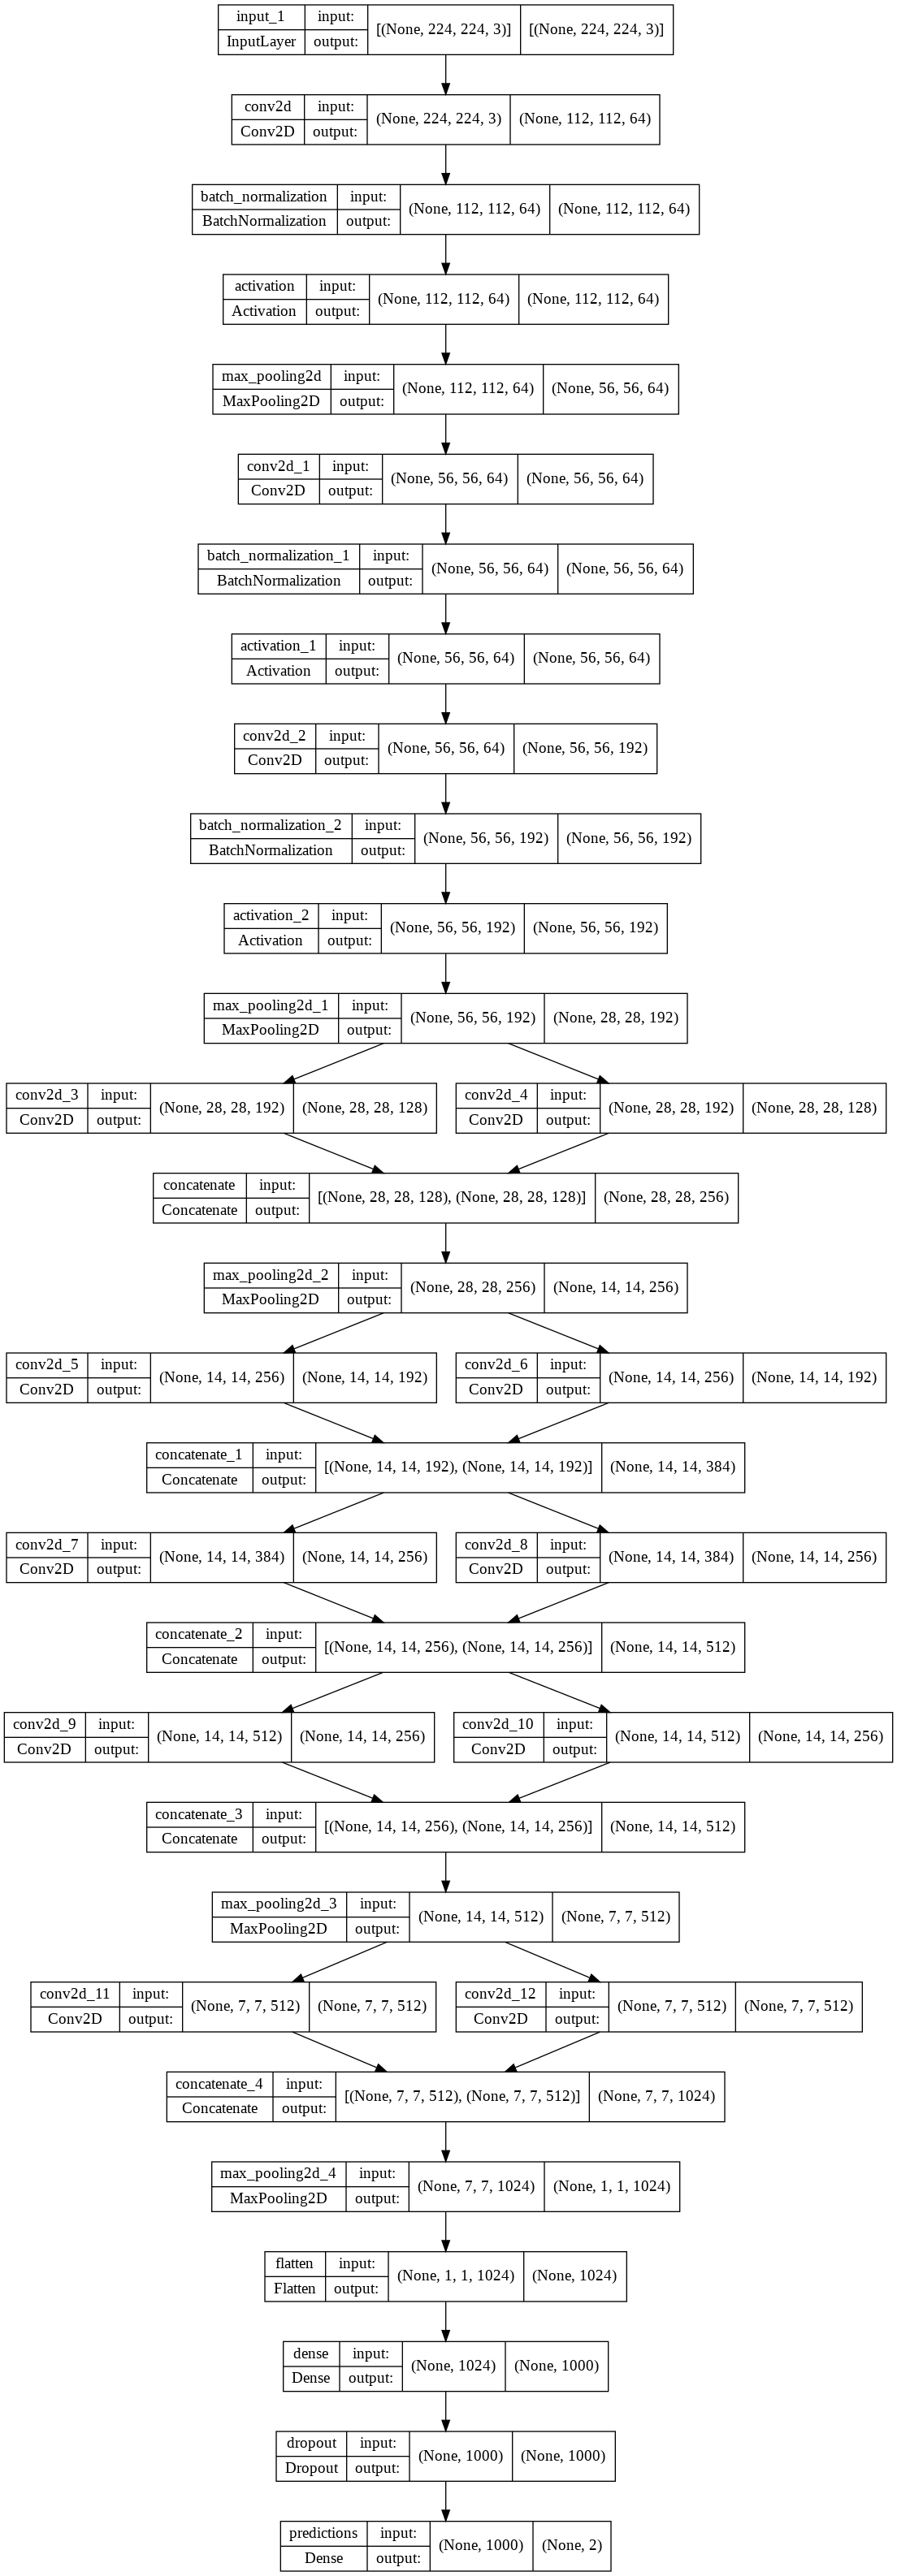

In [13]:
# Create model.
inputs = img_input
model =  keras.Model(inputs, x, name='OurModel_v7')
model.summary()


# plot model architecture
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='our_model_V6.png')

In [14]:
model.compile(loss='categorical_crossentropy',optimizer = 'adam', metrics= 'accuracy')

In [15]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("AlexNet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.4, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [16]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =20, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/20
72/72 [==============================] - ETA: 0s - loss: 0.7574 - accuracy: 0.7287
Epoch 1: val_accuracy improved from -inf to 0.76562, saving model to AlexNet.h5
72/72 [==============================] - 21s 100ms/step - loss: 0.7574 - accuracy: 0.7287 - val_loss: 0.5332 - val_accuracy: 0.7656 - lr: 0.0010
Epoch 2/20
72/72 [==============================] - ETA: 0s - loss: 0.3607 - accuracy: 0.8602
Epoch 2: val_accuracy did not improve from 0.76562
72/72 [==============================] - 5s 75ms/step - loss: 0.3607 - accuracy: 0.8602 - val_loss: 0.7016 - val_accuracy: 0.6016 - lr: 0.0010
Epoch 3/20
72/72 [==============================] - ETA: 0s - loss: 0.2764 - accuracy: 0.8855
Epoch 3: val_accuracy did not improve from 0.76562

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
72/72 [==============================] - 5s 75ms/step - loss: 0.2764 - accuracy: 0.8855 - val_loss: 0.6066 - val_accuracy: 0.6211 - lr: 0.0010
Epoch 4/20
72/72 [==========

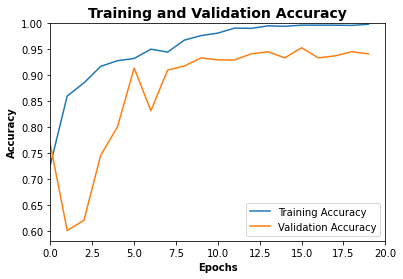

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy',fontweight='bold')
plt.xlim([0,20])
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy',fontweight='bold', fontsize=14)
plt.xlabel('Epochs',fontweight='bold')
# plt.legend(loc='best')
plt.savefig('ProposedV6TV1',dpi=400)
plt.show()

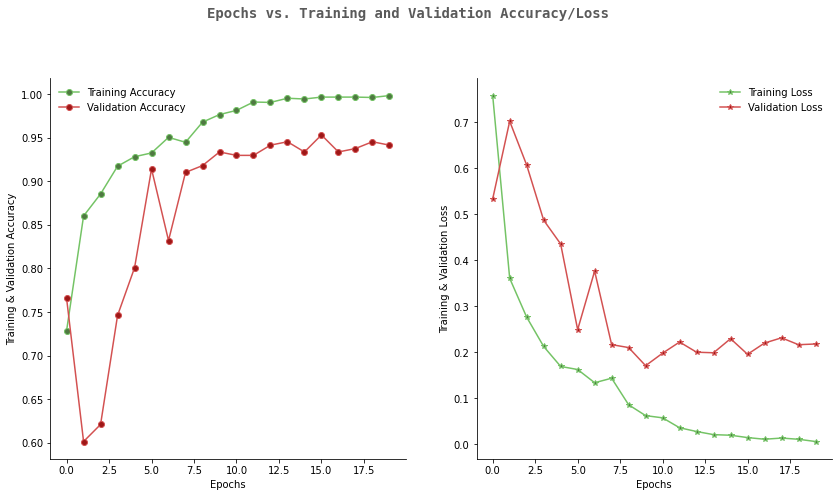

In [18]:
filterwarnings('ignore')

epochs = [i for i in range(20)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=14,fontweight='bold',
             fontname='monospace',color='#313131',y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor='#4F7942',color='#74C365',
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor='#9E1717',color='#D35151',
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training & Validation Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='*',markerfacecolor='#4F7942',color='#74C365',
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='*',markerfacecolor='#9E1717',color='#D35151',
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')
plt.savefig('ProposedV6TV2',dpi=400)
fig.show()

In [19]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [20]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       380
           1       0.91      0.92      0.91       258

    accuracy                           0.93       638
   macro avg       0.93      0.93      0.93       638
weighted avg       0.93      0.93      0.93       638



In [21]:
cm = confusion_matrix(y_test_new, pred)

Confusion matrix, without normalization


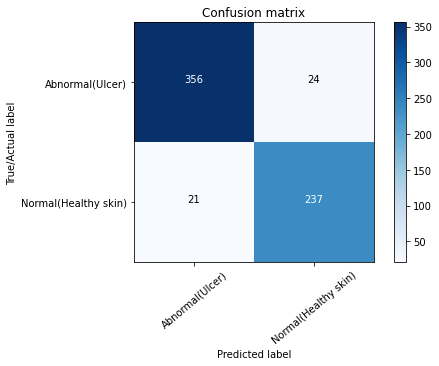

In [22]:
import itertools
from itertools import product
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    
    plt.figure(figsize=(7,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=40)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True/Actual label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm,labels)
plt.savefig('OurProposedV6ModelCM',dpi=400)

In [23]:
TP=cm[1,1]
TN=cm[0,0]
FP=cm[0,1]
FN=cm[1,0]

In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,confusion_matrix, roc_curve, auc,roc_auc_score

print('Accuracy: %.3f' % accuracy_score(y_test_new, pred), 'Precision: %.3f' % precision_score(y_test_new, pred),' Recall: %.3f' % recall_score(y_test_new, pred), 
      'F1 Score: %.3f' % f1_score(y_test_new, pred), 'AUC Score: %.3f' % roc_auc_score(y_test_new, pred))



Accuracy: 0.929 Precision: 0.908  Recall: 0.919 F1 Score: 0.913 AUC Score: 0.928


In [25]:
recall=TP/float(TP+FN)
print(recall)
print(recall_score(y_test_new, pred))

0.9186046511627907
0.9186046511627907


In [26]:
precision=TP/float(TP+FP)
print(precision)

print(precision_score(y_test_new, pred))

0.9080459770114943
0.9080459770114943


In [27]:
print((2*precision*recall)/(recall+precision))
print(f1_score(y_test_new, pred))

0.9132947976878613
0.9132947976878613


In [28]:
specificity=TN/float(TN+FP)
print(specificity)

0.9368421052631579


In [29]:
print(TP/float(TP+FN))
print(recall_score(y_test_new, pred))

0.9186046511627907
0.9186046511627907


In [30]:
print(roc_auc_score(y_test_new, pred))

0.9277233782129742


In [31]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test_new, pred)

0.07053291536050156

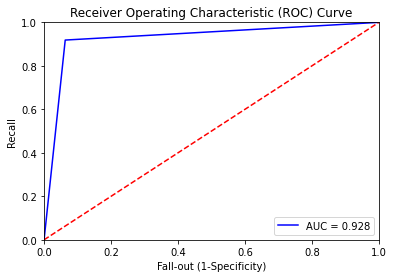

In [32]:
#Print Area Under Curve
false_positive_rate, recall, thresholds = roc_curve(y_test_new, pred)
roc_auc = auc(false_positive_rate, recall)
plt.figure()
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

In [33]:
acc = accuracy_score(y_test_new, pred)*100
auc=roc_auc_score(y_test_new, pred)*100
tn, fp, fn, tp = cm.ravel()
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
specificity = tn/(tn+fp)*100
print('Accuracy: {0:0.2f}%'.format(acc))
print('Precision: {0:0.2f}%'.format(precision))
print('Recall or Sensitivity: {0:0.2f}%'.format(recall))
print('Specificity: {0:0.2f}%'.format(specificity))
print('F1-score: {0:0.2f}%'.format(2*precision*recall/(precision+recall)))
print('AUC-score: {0:0.2f}%'.format(auc))
print('Train acc: {0:0.2f}%'.format(np.round((history.history['accuracy'][-1])*100, 2)))

Accuracy: 92.95%
Precision: 90.80%
Recall or Sensitivity: 91.86%
Specificity: 93.68%
F1-score: 91.33%
AUC-score: 92.77%
Train acc: 99.83%
